Примеры:
* https://github.com/bigartm/bigartm-book/blob/master/ARTM_example_RU.ipynb
* https://github.com/bigartm/bigartm-book/blob/master/ARTM_tutorial_RU.ipynb
* http://localhost:8888/notebooks/examples/2/%D0%94%D0%B5%D0%BC%D0%BE%D0%BD%D1%81%D1%82%D1%80%D0%B0%D1%86%D0%B8%D1%8F-BigARTM-0.8.0.ipynb

In [1]:
%matplotlib inline
import glob
import os
import matplotlib.pyplot as plt

import artm

# Адрес, по которому находятся данные
BATCH_ADRESS = 'batches_news'

# Вывод версии BigARTM
print(artm.version())

0.10.0


In [2]:
# Установка адреса, по которому находятся данные
batch_vectorizer = artm.BatchVectorizer(
    data_path=BATCH_ADRESS, data_format='batches'
)

In [3]:
# Пересоздание словаря для модели и сохранение его в файл

# Устанавливается название словаря для модели
dictionary_address = BATCH_ADRESS + '/dictionary.dict'

# Инициализация словоря для модели
dictionary = artm.Dictionary()

# Удаление словаря, оставшегося после предыдущих запусков
if os.path.isfile(dictionary_address):
    os.remove(dictionary_address)
    
# Сохранение словаря в файл
dictionary.gather(data_path=batch_vectorizer.data_path)
dictionary.save(dictionary_path=dictionary_address)

# Загрузка словаря из файла
dictionary.load(dictionary_path=dictionary_address)
print("Количество слов в словаре:", dictionary.__dict__['_master'].get_info().dictionary[0].num_entries)


# Фильтрация

# Убираются слова, которые попадаются меньше чем в n процентов документов
dictionary.filter(min_df_rate=0.01)
print(
    "Количество слов в словаре после фильтрации по min_df_rate:", 
    dictionary.__dict__['_master'].get_info().dictionary[0].num_entries
)

# Убираются слова, которые попадаются больше чем в n процентов документов
dictionary.filter(max_df_rate=0.5)
print(
    "Количество слов в словаре после фильтрации по max_df_rate:", 
    dictionary.__dict__['_master'].get_info().dictionary[0].num_entries
)

# Убираются редкие слова по всей коллекции
# Слово встречается во всей коллекции больше чем n раз
dictionary.filter(min_tf=10)
print(
    "Количество слов в словаре после фильтрации по min_tf:", 
    dictionary.__dict__['_master'].get_info().dictionary[0].num_entries
)

# Убираются частые слова по всей коллекции
# Слово встречается во всей коллекции меньше чем n раз
dictionary.filter(max_tf=2000)
print(
    "Количество слов в словаре после фильтрации по max_tf:", 
    dictionary.__dict__['_master'].get_info().dictionary[0].num_entries
)

Количество слов в словаре: 75725
Количество слов в словаре после фильтрации по min_df_rate: 2363
Количество слов в словаре после фильтрации по max_df_rate: 2358
Количество слов в словаре после фильтрации по min_tf: 2358
Количество слов в словаре после фильтрации по max_tf: 1819


In [4]:
def new_default_model(topic_count, dictionary):
    
    # Создание модели
    model_artm = artm.ARTM(
        topic_names=['topic_{}'.format(i) for i in range(topic_count)], 
        cache_theta=True,
        #class_ids={'text': 1.0},
    )

    # Инициализация модели
    model_artm.initialize(dictionary=dictionary)
    model_artm.num_document_passes = 1

    # Установка отслеживаемых параметров
    # Перплексия (чем она меньше тем лучше)
    model_artm.scores.add(artm.PerplexityScore(name='PerplexityScore'))
    # Разреженность матрицы Phi (доля почти нулевых значений)
    model_artm.scores.add(artm.SparsityPhiScore(name='SparsityPhiScore'))
    # Разреженность матрицы Theta (доля почти нулевых значений)
    model_artm.scores.add(artm.SparsityThetaScore(name='SparsityThetaScore'))
    # Анализ самых используемых слов по темам
    model_artm.scores.add(artm.TopTokensScore(name='TopTokensScore', num_tokens=10))
    # Анализ ядра тем на контраст и чистоту
    model_artm.scores.add(artm.TopicKernelScore(name='TopicKernelScore'))
    #model_artm.scores.add(artm.TopicKernelScore(name='TopicKernelScore', probability_mass_threshold=0.3))
    
    return model_artm

In [11]:
def model_print_results(model_artm):
    
    # Графики
    
    fig = plt.figure(figsize=(15, 20))

    ax = fig.add_subplot(331) 
    ax.plot(model_artm.score_tracker["PerplexityScore"].value)
    ax.set_xlabel('Iterations count')
    ax.set_ylabel('PerplexityScore')
    ax.grid(True)
    
    ax = fig.add_subplot(332)  
    ax.plot(model_artm.score_tracker["SparsityPhiScore"].value)
    ax.set_xlabel('Iterations count')
    ax.set_ylabel('SparsityPhiScore')
    ax.grid(True)
    ax.set_ylim([0,1])

    ax = fig.add_subplot(333)  
    ax.plot(model_artm.score_tracker["SparsityThetaScore"].value)
    ax.set_xlabel('Iterations count')
    ax.set_ylabel('SparsityThetaScore')
    ax.grid(True)
    ax.set_ylim([0,1])
    
    ax = fig.add_subplot(334)  
    ax.plot(model_artm.score_tracker["TopicKernelScore"].average_contrast)
    ax.set_xlabel('Iterations count')
    ax.set_ylabel('TopicKernelScore_average_contrast')
    ax.grid(True)
    ax.set_ylim([0,1])
    
    ax = fig.add_subplot(335)  
    ax.plot(model_artm.score_tracker['TopicKernelScore'].average_purity)
    ax.set_xlabel('Iterations count')
    ax.set_ylabel('TopicKernelScore_average_purity')
    ax.grid(True)
    ax.set_ylim([0,1])
    
    ax = fig.add_subplot(336)  
    ax.plot(model_artm.score_tracker['TopicKernelScore'].average_size)
    ax.plot([model_artm.phi_.shape[0]/model_artm.num_topics for i in range(len(model_artm.score_tracker['TopicKernelScore'].average_size))])
    ax.set_xlabel('Iterations count')
    ax.set_ylabel('TopicKernelScore_average_size')
    ax.grid(True)
    
    plt.show()
    
    
    # Конечные значения
    
    print("PerplexityScore:", model_artm.score_tracker["PerplexityScore"].last_value)
    print("SparsityPhiScore:", model_artm.score_tracker["SparsityPhiScore"].last_value)
    print("SparsityThetaScore:", model_artm.score_tracker["SparsityThetaScore"].last_value)
    print()
    print("TopicKernelScore_average_contrast:", model_artm.score_tracker["TopicKernelScore"].last_average_contrast)
    print("TopicKernelScore_average_purity:", model_artm.score_tracker['TopicKernelScore'].last_average_purity)
    print("TopicKernelScore_average_size:", model_artm.score_tracker['TopicKernelScore'].last_average_size)
    
    print()
    
    
    # Главные слова в темах
    
    print("TopTokensScore:")
    topic_list = list(model_artm.score_tracker['TopTokensScore'].last_tokens.keys())
    for topic_name in topic_list:
        print(topic_name + ': ', end='')
        print(model_artm.score_tracker['TopTokensScore'].last_tokens[topic_name])

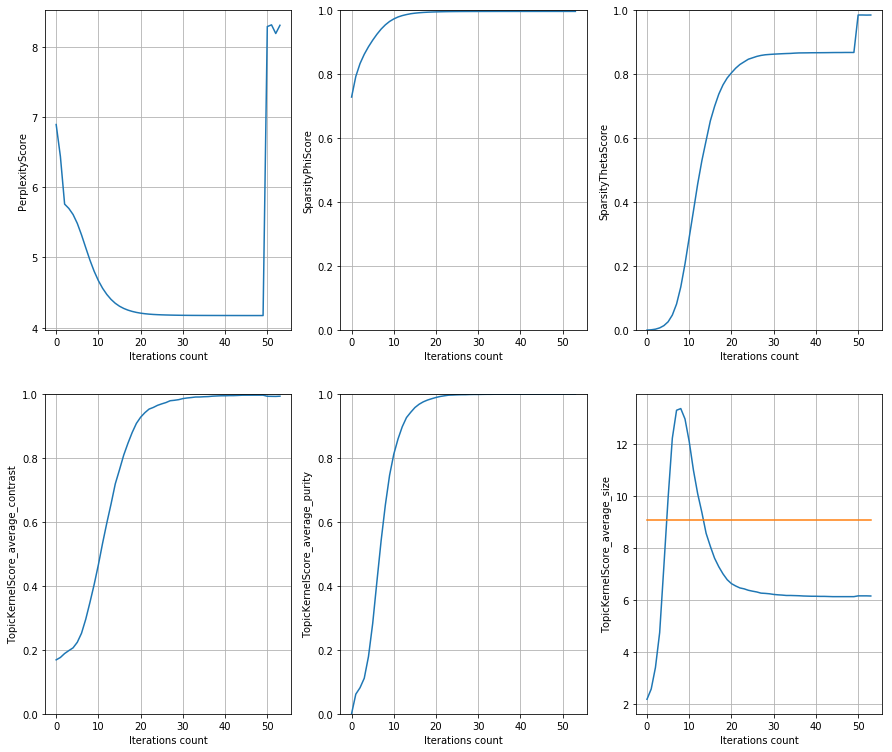

PerplexityScore: 8.307069778442383
SparsityPhiScore: 0.9966052770614624
SparsityThetaScore: 0.9853225350379944

TopicKernelScore_average_contrast: 0.9932621121406555
TopicKernelScore_average_purity: 0.999876856803894
TopicKernelScore_average_size: 6.170000076293945

TopTokensScore:
topic_0: ['умирать', 'лечение', 'тяжелый', 'поставлять', 'болезнь', 'диагноз']
topic_1: ['волков', 'волк', 'леонид', 'вячеслав', 'криминальный']
topic_2: ['военнослужащий', 'одежда', 'правда', 'солдат', 'сдавать', 'последствие', 'немой']
topic_3: ['зарплата', 'банк', 'бюджет', 'выплата', 'население']
topic_4: ['илья', 'студент', 'черный', 'университет']
topic_5: ['подросток', 'кабинет', 'школьник', 'класс', 'артем', 'избрание']
topic_6: ['здесь', 'думать', 'например', 'любой', 'постоянно', 'уверенный', 'опять', 'внутри', 'использоваться', 'покупка']
topic_7: ['хороший', 'брать', 'действительно', 'подписка', 'бывать', 'бояться', 'невыезд']
topic_8: ['течение', 'конституционный', 'транспорт', 'поселение', 'дач

In [ ]:
model_print_results(model_artm)

In [6]:
params = {
    'topic_count': 200,
    'num_collection_passes': 50,
    'SparsePhi': {
        'name': 'SparsePhi',
        'tau': -5
    },
    'SparseTheta': {
        'name': 'SparseTheta',
        'tau': -3
    },
}

In [7]:
# Базовая пустая модель
model_artm = new_default_model(params['topic_count'], dictionary)
model_artm.save("news_model_0")

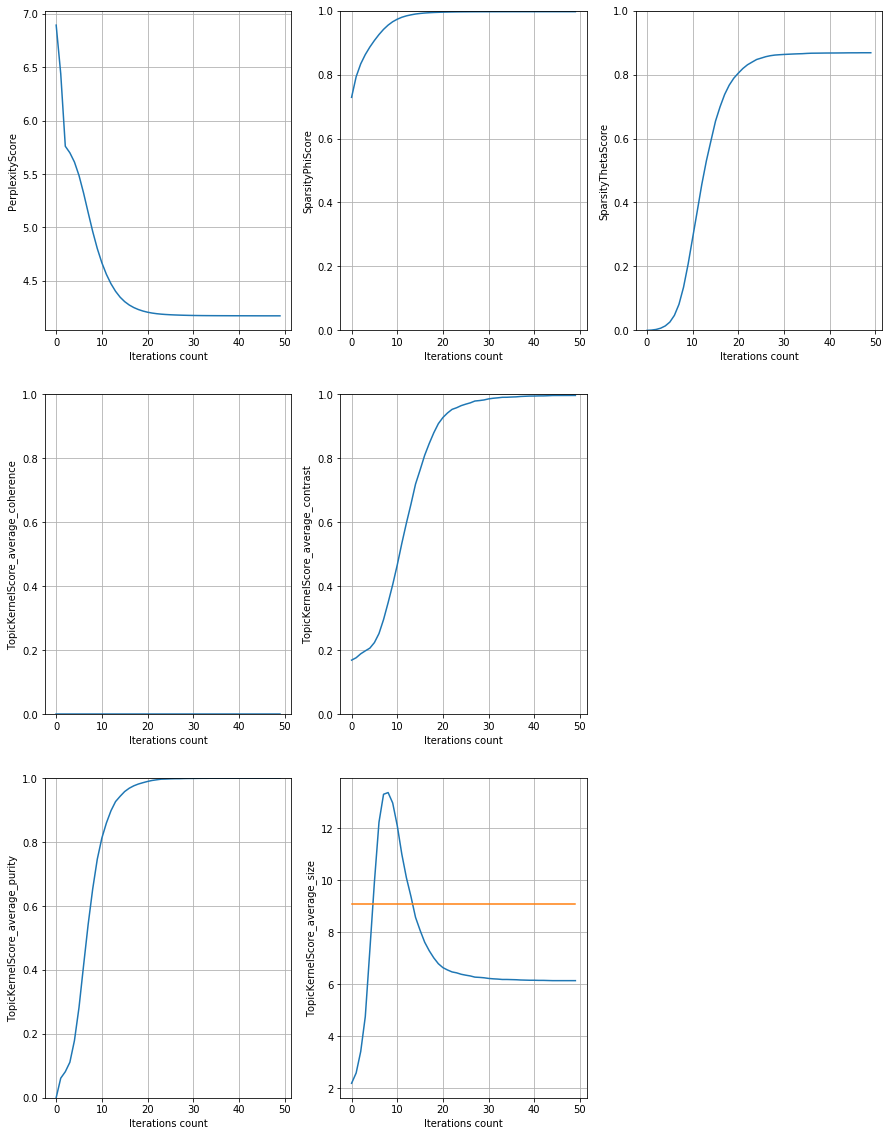

PerplexityScore: 4.172637939453125
SparsityPhiScore: 0.9966052770614624
SparsityThetaScore: 0.8681911826133728

TopicKernelScore_average_contrast: 0.9964854717254639
TopicKernelScore_average_purity: 0.9998552203178406

TopTokensScore:
topic_0: ['умирать', 'поставлять', 'тяжелый', 'лечение', 'болезнь', 'диагноз']
topic_1: ['вячеслав', 'волков', 'волк', 'леонид', 'криминальный']
topic_2: ['одежда', 'военнослужащий', 'правда', 'последствие', 'сдавать', 'немой', 'солдат']
topic_3: ['банк', 'зарплата', 'бюджет', 'выплата', 'население']
topic_4: ['илья', 'черный', 'студент', 'университет']
topic_5: ['подросток', 'кабинет', 'артем', 'избрание', 'школьник', 'класс']
topic_6: ['здесь', 'думать', 'постоянно', 'уверенный', 'внутри', 'опять', 'например', 'покупка', 'использоваться', 'любой']
topic_7: ['действительно', 'хороший', 'подписка', 'брать', 'невыезд', 'бывать', 'бояться']
topic_8: ['течение', 'отмечаться', 'поселение', 'дача', 'конституционный', 'транспорт']
topic_9: ['восемь', 'угрожать'

topic_94: ['собственный', 'денис', 'ранить', 'клиент', 'республиканский', 'перестрелка']
topic_95: ['запрос', 'исследование', 'история', 'книга', 'копия', 'свидетельствовать', 'опрос']
topic_96: ['млрд', 'возглавлять', 'объем', 'вход', 'переставать', 'сокращать', 'прокомментировать', 'пресса']
topic_97: ['дверь', 'этаж', 'психиатрический', 'поджигать']
topic_98: ['посещать', 'лишать', 'середина', 'признательный', 'запрашивать']
topic_99: ['охрана', 'офицер', 'нацгвардия', 'командир', 'армия', 'войско']
topic_100: ['мало', 'строительство', 'часто', 'обычно', 'иногда', 'этап']
topic_101: ['законный', 'норма', 'соответствующий', 'палата', 'конституция', 'объединение']
topic_102: ['предприятие', 'завод', 'важный', 'практика', 'например', 'впрочем', 'превышать']
topic_103: ['кровь', 'переписка', 'жилой', 'собака', 'очевидец', 'животное']
topic_104: ['детский', 'мальчик', 'лагерь', 'стена', 'заведомо']
topic_105: ['сторонник', 'екатеринбург', 'волонтер', 'ленинский', 'вчера']
topic_106: ['ис

topic_187: ['фейсбук', 'елена', 'девять', 'оформлять', 'объяснение', 'неповиновение', 'шествие', 'ярославский']
topic_188: ['имущество', 'окно', 'поджог', 'ингушетия', 'площадка', 'уничтожение']
topic_189: ['аэропорт', 'самолет', 'пассажир', 'забайкальский', 'минобороны']
topic_190: ['принадлежать', 'продажа', 'краевой', 'реестр', 'сервис', 'приморский', 'краснодар']
topic_191: ['форма', 'вновь', 'глаз', 'жаловаться', 'вывозить', 'довод']
topic_192: ['покушение', 'канал', 'скрываться', 'проспект', 'телегр']
topic_193: ['телеканал', 'пристав', 'дождь', 'профессиональный', 'грозить']
topic_194: ['граница', 'программа', 'положение', 'продавать']
topic_195: ['увидеть', 'снова', 'относиться', 'красный', 'поведение', 'встречать', 'временный', 'предел', 'исследовать']
topic_196: ['никогда', 'всегда', 'коллегия', 'большинство', 'банда', 'следить', 'организованный', 'вариант']
topic_197: ['вступать', 'менее', 'боевой', 'десяток', 'аналогичный', 'восток']
topic_198: ['связанный', '2010', 'предуп

In [8]:
# Модель 1_1
# Запуск регуляризатора SparsePhi

model_artm = new_default_model(params['topic_count'], dictionary)
model_artm.load("news_model_0")

if params['SparsePhi']['name'] not in list(model_artm.regularizers.data):
    model_artm.regularizers.add(artm.SmoothSparsePhiRegularizer(name=params['SparsePhi']['name']))
model_artm.regularizers[params['SparsePhi']['name']].tau = params['SparsePhi']['tau']

model_artm.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=params['num_collection_passes'])
model_print_results(model_artm)

model_artm.save("news_model_1_1")

In [9]:
# Модель 1_2
# Запуск регуляризатора SparseTheta к уже включенному SparsePhi

#model_artm = new_default_model(params['topic_count'], dictionary)
#model_artm.load("news_model_1_1")

if params['SparsePhi']['name'] not in list(model_artm.regularizers.data):
    model_artm.regularizers.add(artm.SmoothSparsePhiRegularizer(name=params['SparsePhi']['name']))
model_artm.regularizers[params['SparsePhi']['name']].tau = params['SparsePhi']['tau']
    
if params['SparseTheta']['name'] not in list(model_artm.regularizers.data):
    model_artm.regularizers.add(artm.SmoothSparseThetaRegularizer(name=params['SparseTheta']['name']))
model_artm.regularizers[params['SparseTheta']['name']].tau = params['SparseTheta']['tau']

model_artm.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=params['num_collection_passes'])
model_print_results(model_artm)

model_artm.save("news_model_1_2")

Exception ignored in: <generator object tqdm_notebook.__iter__ at 0x1117610a0>
Traceback (most recent call last):
  File "/Users/kirkira/Code/anaconda3/lib/python3.6/site-packages/tqdm/_tqdm_notebook.py", line 228, in __iter__
    self.sp(bar_style='danger')
AttributeError: 'tqdm_notebook' object has no attribute 'sp'


KeyboardInterrupt: 

In [ ]:
# Модель 2_1
# Запуск регуляризаторов SparsePhi и SparseTheta одновременно и сначала обучения

model_artm = new_default_model(params['topic_count'], dictionary)
model_artm.load("news_model_0")

if params['SparsePhi']['name'] not in list(model_artm.regularizers.data):
    model_artm.regularizers.add(artm.SmoothSparsePhiRegularizer(name=params['SparsePhi']['name']))
model_artm.regularizers[params['SparsePhi']['name']].tau = params['SparsePhi']['tau']
    
if params['SparseTheta']['name'] not in list(model_artm.regularizers.data):
    model_artm.regularizers.add(artm.SmoothSparseThetaRegularizer(name=params['SparseTheta']['name']))
model_artm.regularizers[params['SparseTheta']['name']].tau = params['SparseTheta']['tau']

model_artm.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=params['num_collection_passes'])
model_print_results(model_artm)

model_artm.save("news_model_2_1")

In [45]:
model_artm.phi_.shape[0]

1819

In [46]:
model_artm.phi_.shape[0]/model_artm.num_topics

90.95

In [35]:
model_artm.score_tracker['TopicKernelScore'].coherence

[{'topic_0': 0.0,
  'topic_1': 0.0,
  'topic_10': 0.0,
  'topic_11': 0.0,
  'topic_12': 0.0,
  'topic_13': 0.0,
  'topic_14': 0.0,
  'topic_15': 0.0,
  'topic_16': 0.0,
  'topic_17': 0.0,
  'topic_18': 0.0,
  'topic_19': 0.0,
  'topic_2': 0.0,
  'topic_3': 0.0,
  'topic_4': 0.0,
  'topic_5': 0.0,
  'topic_6': 0.0,
  'topic_7': 0.0,
  'topic_8': 0.0,
  'topic_9': 0.0},
 {'topic_0': 0.0,
  'topic_1': 0.0,
  'topic_10': 0.0,
  'topic_11': 0.0,
  'topic_12': 0.0,
  'topic_13': 0.0,
  'topic_14': 0.0,
  'topic_15': 0.0,
  'topic_16': 0.0,
  'topic_17': 0.0,
  'topic_18': 0.0,
  'topic_19': 0.0,
  'topic_2': 0.0,
  'topic_3': 0.0,
  'topic_4': 0.0,
  'topic_5': 0.0,
  'topic_6': 0.0,
  'topic_7': 0.0,
  'topic_8': 0.0,
  'topic_9': 0.0},
 {'topic_0': 0.0,
  'topic_1': 0.0,
  'topic_10': 0.0,
  'topic_11': 0.0,
  'topic_12': 0.0,
  'topic_13': 0.0,
  'topic_14': 0.0,
  'topic_15': 0.0,
  'topic_16': 0.0,
  'topic_17': 0.0,
  'topic_18': 0.0,
  'topic_19': 0.0,
  'topic_2': 0.0,
  'topic_3': 0

In [30]:
help(model_artm.score_tracker['TopicKernelScore'])

Help on TopicKernelScoreTracker in module artm.score_tracker object:

class TopicKernelScoreTracker(BaseScoreTracker)
 |  Method resolution order:
 |      TopicKernelScoreTracker
 |      BaseScoreTracker
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __init__(self, score)
 |      :Properties:
 |      * Note: every field is a list of info about score on all synchronizations.
 |      * tokens - each element of list is a dict, key - topic name, value - list of kernel tokens
 |      * size - each element of list is a dict, key - topic name, value - kernel size
 |      * contrast - each element of list is a dict, key - topic name, value - kernel contrast
 |      * purity - each element of list is a dict, key - topic name, value - kernel purity
 |      * coherence - each element of list is a dict, key - topic name, value - topic coherence                      counted using kernel tokens
 |      * average_size - average kernel size of all scored topics.
 |      * average_cont

In [131]:
# Установка регуляризаторов
model_artm.regularizers.add(artm.SmoothSparsePhiRegularizer(name='SparsePhi'))
#model_artm.regularizers.add(artm.SmoothSparseThetaRegularizer(name='SparseTheta'))
#model_artm.regularizers.add(artm.DecorrelatorPhiRegularizer(name='DecorrelatorPhi'))


#model_artm.regularizers.add(artm.TopicSelectionThetaRegularizer(name='TopicSelectionTheta', tau=0.1))

In [132]:
# Правка регуляризаторов
model_artm.regularizers['SparsePhi'].tau = -3
#model_artm.regularizers['SparseTheta'].tau = -2
#model_artm.regularizers['DecorrelatorPhi'].tau = 2.5e+5

Полезные идеи по нулевым значениям:
https://github.com/bigartm/bigartm/issues/664